In [1]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

In [13]:
from __future__ import division

import sys


import matplotlib.pyplot as plt
from nilearn import plotting
import numpy as np
import pandas as pd

import sklearn
from sklearn.cross_validation import ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from sklearn.svm import LinearSVR, LinearSVC

import entrainment_pred

In [65]:
full_atw = pd.read_csv("data/step3/full_atw.csv")
data_atw, target_atw = entrainment_pred.separate(full_atw, 'atw_z')
data_atw_df, target_atw_df = entrainment_pred.separate(full_atw, 'atw_diff_wpm')

full_adw = pd.read_csv("data/step3/full_adw.csv")
data_adw, target_adw = entrainment_pred.separate(full_adw, 'adw_z')

In [119]:
def log_dir_f(f_name):
    import os
    return os.path.join("data/step4/both_hemi/", f_name)

def load_logged_csv(f_name):
    return np.loadtxt(log_dir_f(f_name), delimiter=',')

### Create Best Pipelines

In [115]:
!cat {log_dir_f('search_results.log')} | grep "best params:"

INFO:atw_z:best params: {'svr__C': 0.098454657585896929}
INFO:atw_diff_wpm:best params: {'svr__C': 0.0062987888851660616}
INFO:adw_z:best params: {'svr__C': 0.060487930870555311}


In [117]:
!cat {log_dir_f('search_results.log')} | grep "norm"

INFO:atw_z:normalized: yes
INFO:atw_diff_wpm:normalized: no
INFO:adw_z:normalized: yes


In [67]:
def create_shuffle_split(target):
    return ShuffleSplit(len(target), 
                        n_iter=100, 
                        test_size=1/6.0, random_state=1234)


data_atw = scale(data_atw)
svr_atw = LinearSVR(C=0.098454657585896929)
pipe_atw = Pipeline([('svr', svr_atw)])
cv_atw = create_shuffle_split(target_atw)

data_atw_df = data_atw_df.get_values()
svr_atw_df = LinearSVR(C=0.0062987888851660616)
pipe_atw_df = Pipeline([('svr', svr_atw_df)])
cv_atw_df = create_shuffle_split(target_atw_df)

data_adw = scale(data_adw)
svr_adw = LinearSVR(C=0.060487930870555311)
pipe_adw = Pipeline([('svr', svr_adw)])
cv_adw = create_shuffle_split(target_adw)

### Calculate Coefficients and Plot Closeness to Fit

In [22]:
def plot(predict_hist, target, title, sort=True, agg=np.mean, save=True):
    pmns = np.array([agg(predict_hist[i]) for i in predict_hist.keys()])
    
    plt_indices = np.argsort(target) if sort else x
    plt_indices = plt_indices[plt_indices.apply(lambda i: len(predict_hist[i]) > 0)]
    
    x = np.array(range(len(plt_indices)))
    
    pmns = pmns[plt_indices]
    target = target.get_values()[plt_indices]
    
    plt.scatter(x, pmns, c='y')
    
    p = plt.plot(x, target, marker='*')
    plt.title(title)
    plt.legend(["truth", "mean pred."], bbox_to_anchor=[.9, 1.0])
    msg = 'corr: %.2f' % np.corrcoef(
        pmns, target)[0][1]
    plt.text(.6, .95, msg, verticalalignment='top', fontsize=12, 
         horizontalalignment='right', transform=p[0].axes.transAxes)
    
    m, b = np.polyfit(x, pmns, 1)
    plt.plot(x, m*x + b, '-')
    
    if save:
        plt.savefig(title + '.jpg')

In [23]:
def calc_coeffs(best_estimator, cv, data, target, verbose=True):

    def _calc_coeffs(predicted_hist):
        n_iter = cv.n_iter
        if verbose: print('-' * n_iter)

        svr = best_estimator.named_steps['svr']
        def fit(train):
            best_estimator.fit(data[train], target[train])

        def predict(test):
            predicted = best_estimator.predict(data[test]).tolist()
            for i in test:
                predicted_hist[i].append(predicted.pop(0))

        def coeffs_fn():
            if verbose: sys.stdout.write('#')
            return svr.coef_.copy()

        coeffs = entrainment_pred.calc_coeffs(cv, fit, coeffs_fn, predict)
        return coeffs, predicted_hist
    
    return _calc_coeffs({i:[] for i in range(len(target))})
    

In [68]:
coeffs_adw, predict_hist_adw = calc_coeffs(pipe_adw, cv_adw, 
                                           data_adw, target_adw)
coeffs_atw, predict_hist_atw = calc_coeffs(pipe_atw, cv_atw, 
                                           data_atw, target_atw)
coeffs_atw_df, predict_hist_atw_df = calc_coeffs(pipe_atw_df, cv_atw_df, 
                                           data_atw_df, target_atw_df)

----------------------------------------------------------------------------------------------------
####################################################################################################----------------------------------------------------------------------------------------------------
####################################################################################################----------------------------------------------------------------------------------------------------
####################################################################################################

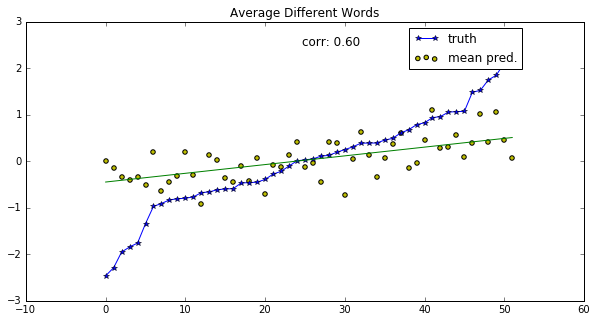

In [69]:
plot(predict_hist_adw, target_adw, 'Average Different Words')

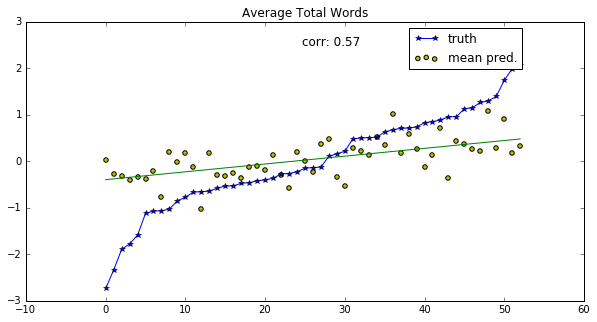

In [70]:
plot(predict_hist_atw, target_atw, 'Average Total Words')

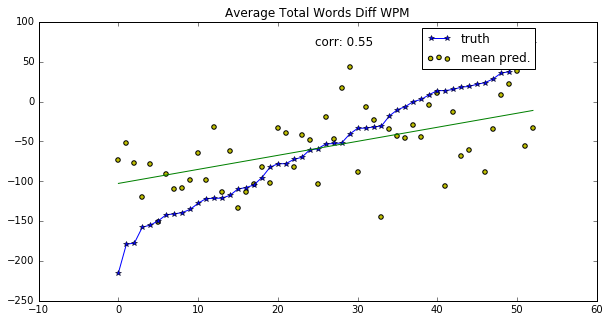

In [71]:
plot(predict_hist_atw_df, target_atw_df, 'Average Total Words Diff WPM')

### Plot Permutation Curve

In [118]:
!cat {log_dir_f("search_results.log")} | grep "best score:"

INFO:atw_z:best score: 0.0841486680109
INFO:atw_diff_wpm:best score: 0.169099889956
INFO:adw_z:best score: 0.0997514050901


In [34]:
best_score_atw = 0.0841486680109
best_score_atw_df = 0.169099889956
best_score_adw = 0.0997514050901

In [56]:
permute_pred_scores_atw = load_logged_csv('atw_z_permute_pred_scores.csv')
permute_pred_scores_atw_df = load_logged_csv('atw_diff_wpm_permute_pred_scores.csv')
permute_pred_scores_adw = load_logged_csv('adw_z_permute_pred_scores.csv')

In [59]:
def plot_perm_scores(permute_scores, best_score, label):
    plt.hist(permute_scores, 20, label='Permutation scores ' + label);
    ylim = plt.ylim()
    plt.plot(2 * [best_score], ylim, '--g', linewidth=3,
             label='Classification Score')

    plt.ylim(ylim);
    plt.legend();
    plt.xlabel('Score');

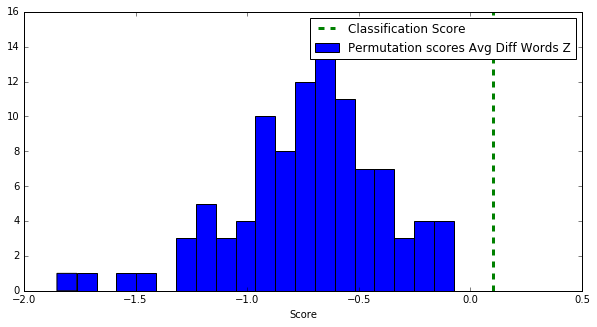

In [60]:
plot_perm_scores(permute_pred_scores_adw, best_score_adw, "Avg Diff Words Z")

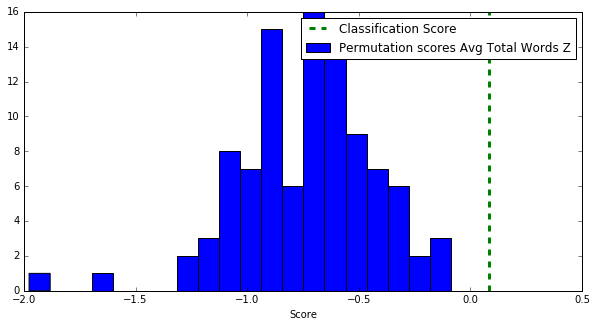

In [61]:
plot_perm_scores(permute_pred_scores_atw, best_score_atw, "Avg Total Words Z")

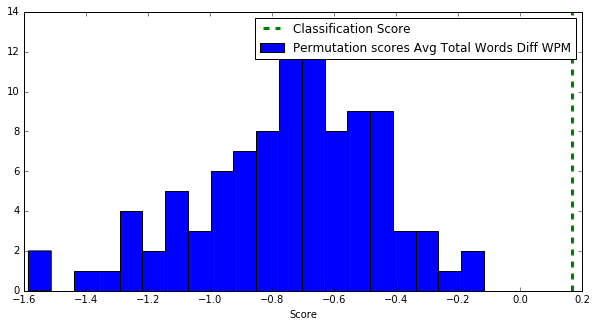

In [62]:
plot_perm_scores(permute_pred_scores_atw_df, best_score_atw_df, "Avg Total Words Diff WPM")

### Get Best Coefs

In [122]:
def load_csv(f_name):
    return load_logged_csv(f_name)

def valid_coefs(prefix, cutoff=.05):
    flat_coefs = load_csv(prefix + '_best_coefs.csv')
    perm_pos_coefs = np.sort(load_csv(prefix + '_permute_max_coefs.csv'))
    perm_neg_coefs = np.sort(load_csv(prefix + '_permute_min_coefs.csv'))
    
    valid_pos = flat_coefs.copy()
    valid_pos[valid_pos < 0] = 0
    
    valid_neg = flat_coefs.copy()
    valid_neg[valid_neg > 0] = 0
    
    if cutoff is not None:
        def within(val, max_val):
            if val < 0:
                return 0
            elif val > max_val:
                return max_val
            else:
                return val
        
        num_pos = len(perm_pos_coefs)
        pos_ix = int((1-cutoff/2) * num_pos)
        pos_ix = within(pos_ix + 1, num_pos - 1)
        pos_c = perm_pos_coefs[pos_ix]
        valid_pos[valid_pos < pos_c] = 0
        
        num_neg = len(perm_neg_coefs)
        neg_ix = int((cutoff/2) * num_neg)
        neg_ix = within(neg_ix - 1, num_neg - 1)
        neg_c = perm_neg_coefs[neg_ix]
        valid_neg[valid_neg > neg_c] = 0
    
    return flat_coefs, valid_pos, valid_neg, perm_pos_coefs, perm_neg_coefs

_, valid_pos_atw, valid_neg_atw, _, _ = valid_coefs('atw_z', cutoff=None)
_, valid_pos_adw, valid_neg_adw, _, _ = valid_coefs('adw_z', cutoff=None)
_, valid_pos_atw_df, valid_neg_atw_df, _, _ = valid_coefs('atw_diff_wpm', cutoff=None)


In [98]:
print (np.sum(valid_pos_atw), np.sum(valid_neg_atw))
print (np.sum(valid_pos_adw), np.sum(valid_neg_adw))
print (np.sum(valid_pos_atw_df), np.sum(valid_neg_atw_df))

(3.2530654492562885, -3.33429573481886)
(3.1406509956470323, -3.3878323887529787)
(34.590168209516577, -44.076925108510558)


In [134]:
def mk_coeffs_mat(coeffs):
    coeffs_mat = np.zeros((189, 189))
    ix = 0
    for i in range(189):
        for j in range(i+1, 189):
            coeffs_mat[i][j] = coeffs_mat[j][i] = coeffs[ix]
            ix += 1
    
    assert np.all(coeffs_mat == coeffs_mat.T)
    return coeffs_mat

### Determine Best Edge Connections

In [253]:
def create_edge_conn_df(coefs_fname, edge_conns):
    coefs = load_csv(coefs_fname)
    
    def conn_to_name(conn):
        jhu_info = entrainment_pred.all_jhu_coordinates()[conn]
        left = jhu_info["left"]
        right = jhu_info['right']
        return "%s--%s" % (left["name"], right["name"])
    
    names = [conn_to_name(c) for c in edge_conns]
    ret = pd.DataFrame(dict(coef=coefs, abs_coef=np.abs(coefs), 
                            edge_conn=edge_conns, name=names))
    ret = ret.sort("abs_coef", ascending=False)
    ret.reset_index(inplace=True, drop=True)
    return ret

In [254]:
edge_conn_df_atw = create_edge_conn_df('atw_z_best_coefs.csv',
                                      filter(entrainment_pred.is_data_col, full_atw))
edge_conn_df_adw = create_edge_conn_df('adw_z_best_coefs.csv',
                                      filter(entrainment_pred.is_data_col, full_adw))
edge_conn_df_atw_wpm = create_edge_conn_df('atw_diff_wpm_best_coefs.csv',
                                      filter(entrainment_pred.is_data_col, full_adw))

/home/lb_lab/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [255]:
edge_conn_df_atw.iloc[0:10]

,abs_coef,coef,edge_conn,name
0,0.002703,0.002703,68_78,PCC_L--Put_L
1,0.002257,0.002257,64_167,subgenual_ACC_L--Mammillary_R
2,0.002178,0.002178,67_165,dorsal_ACC_R--OlfactoryRadiation_R
3,0.002106,-0.002106,121_184,PCR_R--PSTG_R
4,0.002064,-0.002064,73_174,Amyg_R--LV_temporal_L
5,0.002063,0.002063,39_71,MTG_R--Ins_R
6,0.001980,0.001980,32_100,PrCu_L--CST_L
7,0.001964,0.001964,74_75,Hippo_L--Hippo_R
8,0.001942,-0.001942,75_85,Hippo_R--Hypothalamus_R
9,0.001910,-0.001910,121_158,PCR_R--AnsaLenticularis_L


In [256]:
edge_conn_df_atw_wpm.iloc[0:10]

,abs_coef,coef,edge_conn,name
0,0.221224,-0.221224,13_144,IFG_orbitalis_R--Fx_L
1,0.218223,-0.218223,171_175,LV_body_L--LV_frontal_R
2,0.213568,-0.213568,103_167,SCP_R--Mammillary_R
3,0.201257,-0.201257,11_18,IFG_opercularis_R--MFOG_L
4,0.201080,0.201080,114_116,Medulla_L--ACR_L
5,0.190009,0.190009,103_139,SCP_R--CGC_R
6,0.181691,0.181691,28_73,SMG_L--Amyg_R
7,0.176861,-0.176861,27_92,SPG_R--Snigra_L
8,0.171803,0.171803,54_136,IOG_L--EC_L
9,0.171596,-0.171596,6_74,MFG_L--Hippo_L


In [279]:
def calc_roi_stats(df):
    roi_stats = dict()
    def update_counts(roi, name, rank, coef):
        curr = roi_stats.get(roi, dict())
        curr['name'] = name
        curr['roi'] = roi
        curr['coef'] = curr.get('coef', []) + [coef]
        curr['rank'] = curr.get('rank', []) + [rank]
        roi_stats[roi] = curr
    
    for row in df.iterrows():
        rank, row_info = row
        coef, edge_conn, name = row_info[["coef", "edge_conn", "name"]]
        l_name, r_name = name.split("--")
        left, right = edge_conn.split("_")
        
        update_counts(int(left), l_name, rank, coef)
        update_counts(int(right), r_name, rank, coef)
        
    ret_data = [
            dict(
            name=i['name'], 
            roi=i['roi'], 
            coef_med=np.median(i['coef']),
            coef_std=np.std(i['coef']),
            coef_mean=np.mean(i['coef']),
            abs_coef_med=np.abs(np.median(i['coef'])),
            abs_coef_mean=np.abs(np.mean(i['coef'])),
            rank_med=np.median(i['rank']),
            rank_std=np.std(i['rank']),
            rank_mean=np.mean(i['rank']))
            for i in roi_stats.itervalues()
        ]
    return pd.DataFrame(ret_data).sort("abs_coef_med", ascending=False)
        

In [280]:
roi_stats_atw = calc_roi_stats(edge_conn_df_atw)

/home/lb_lab/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:34: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [281]:
roi_stats_atw.iloc[:10, :]

,abs_coef_mean,abs_coef_med,coef_mean,coef_med,coef_std,name,rank_mean,rank_med,rank_std,roi
43,0.000105,0.000105,-0.000105,-0.000105,0.000537,ITG_R,8316.718085,8196.5,5076.706753,43
97,0.000094,0.000082,0.000094,0.000082,0.000454,CP_R,9084.845745,9395.5,4806.618884,97
163,0.000086,0.000078,-0.000086,-0.000078,0.000480,LenticularFasc_R,8347.335106,7921.5,4823.295225,163
9,0.000039,0.000076,0.000039,0.000076,0.000478,MFG_DPFC_R,8778.239362,8671.0,5119.196081,9
138,0.000069,0.000073,0.000069,0.000073,0.000493,CGC_L,8750.500000,8746.0,5150.356590,138
18,0.000088,0.000072,-0.000088,-0.000072,0.000526,MFOG_L,8170.308511,7552.5,5223.356189,18
117,0.000075,0.000071,-0.000075,-0.000071,0.000521,ACR_R,8529.494681,8123.5,5159.843557,117
47,0.000077,0.000068,0.000077,0.000068,0.000519,ENT_R,8614.909574,8595.0,5281.833756,47
150,0.000092,0.000066,-0.000092,-0.000066,0.000501,SS_L,9004.409574,9407.5,5084.078469,150
83,0.000056,0.000064,0.000056,0.000064,0.000511,Thal_R,8075.037234,7742.0,4882.774161,83


In [282]:
roi_stats_adw = calc_roi_stats(edge_conn_df_adw)

/home/lb_lab/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:34: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [283]:
roi_stats_atw_wpm = calc_roi_stats(edge_conn_df_atw_wpm)

/home/lb_lab/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:34: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [271]:
edge_conn_df_atw.to_csv("atw_both_hemi_edge_connections.csv")
edge_conn_df_adw.to_csv("adw_both_hemi_edge_connections.csv")

In [284]:
roi_stats_atw.to_csv("atw_both_hemi_roi_stats.csv")
roi_stats_atw.to_csv("atw_both_hemi_roi_stats.csv")